# <font color='blue'> Tech task - Predict which customers/accounts might be eligible for a loan

### Import basic generic packages

In [5]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

### Read data
#### There are three data files
        - Customer data : basic (static) details of customers with target loan flag
        - districts data : census data from the districts including number of inhabitants, literacy rate, crime rate etc
        - transactions data : account transactions with credit/debit indicator, balances etc
        
    The mapping between the data are as follows:
        - customers['ACCOUNT_ID']-(one-to-many)-> transactions[ACCOUNT_ID']
        - districts['DISTRICT_ID']-(one-to-many)-> customers[DISTRICT_ID']

In [6]:
customers = pd.read_csv('../data_updated/customers.csv')
districts = pd.read_csv('../data_updated/districts.csv')


In [7]:
transactions = pd.read_csv('../data_updated/transactions.csv')

## Follwing sections are taken step-by-step to complete the assessment

#### Section 1 - Basic Data Analysis
#### Section 2 - Feature Engineering
#### Section 3 - Feature Selection
#### Section 4 - Final data preparation for modelling
#### Section 5 - Prepare train test split and define functions for model performance analysis
#### Section 6 - Train and compare models as per performance - base classifier and fine tune with further complex model
#### Section 7 - Analysis of feature importance - from both model and SHAP global importance
#### Section 8 - Run model predictions on test set
#### Section 9 - Further thoughts on what could have been done more in a longer experiment

## <font color='red'>Section 1 - Basic Data Analysis

#### Analyze loans data

In [8]:
customers.shape

(4450, 8)

In [9]:
customers.head()

,CLIENT_ID,ACCOUNT_ID,GENDER,BIRTH_DT,ACTIVE,LOAN,DISTRICT_ID,SET_SPLIT
0,1,1,F,19701213,1,0.0,18,TRAIN
1,2,2,M,19450204,1,1.0,1,TRAIN
2,4,3,M,19561201,1,0.0,5,TEST
3,7,5,M,19290125,1,0.0,15,TRAIN
4,8,6,F,19380221,1,0.0,51,TRAIN


In [10]:
customers['birth_date'] = pd.to_datetime(customers['BIRTH_DT'], format='%Y%m%d')
customers = customers.drop(['BIRTH_DT'],axis = 1)

#### Find earliest date of transaction in accounts - assume that is the inception date. This we will use to create feature for identifying the age of customer during account opening

#### Looks like 'DATE' is taken as numeric so any day like '01101992' has been taken as 1101992
#### So have to convert to date format

In [11]:
import datetime

##### First convert to 8 digits string format by padding starting zero

In [12]:
def convert_to_8_digits_string(date):
    #### If length is less than 8
    if len(str(date))<8:
        #### Set first character as 0
        new_date_as_string = '0'+str(date)
    else:
        new_date_as_string = str(date)
    return new_date_as_string

##### Then convert the string to date format

In [13]:
def feat_eng_convert_date_to_format(df):
    """
    Convert date as string column to date format
        Take dataframe and first convert all entries to string DDMMYYYY format
        Then convert string DDMMYYYY format to python date format
    """
    #### Apply function to convert all dates to string of DDMMYYYY structure
    df['full_date'] = df['DATE'].apply(lambda x: convert_to_8_digits_string(x))

    #### Convert from string to date
    df['date_formatted'] = pd.to_datetime(df['full_date'], format='%d%m%Y')
    
    #### drop other date columns
    df = df.drop(['DATE','full_date'],axis = 1)
    
    return df

#### Apply function to convert date

In [14]:
transactions = feat_eng_convert_date_to_format(transactions)

#### Join customers table with transactions

In [15]:
customers_joined_trans = customers.merge(transactions,on='ACCOUNT_ID',how='left')

#### Convert birth date from string to date format

In [16]:
#### minimum date in transactions file for each account
earliest_date_of_accounts = customers_joined_trans.groupby('ACCOUNT_ID')['date_formatted'].min()\
.reset_index().rename(columns={'date_formatted':'earliest_date'})

#### merge with customers data to get earliest date of transaction
customers = customers.merge(earliest_date_of_accounts,on='ACCOUNT_ID')

#### find what is the year in which customer first transacted, assume that to be account opening year
customers['first_transacted_year'] = customers['earliest_date'].dt.year

#### Find age of customer during account opening/first transaction
customers['age_in_days_during_first_transaction'] = customers['earliest_date']-customers['birth_date']
customers['age_in_years_during_first_transaction'] = customers['age_in_days_during_first_transaction']/datetime.timedelta(days=365)

In [17]:
customers.columns

Index(['CLIENT_ID', 'ACCOUNT_ID', 'GENDER', 'ACTIVE', 'LOAN', 'DISTRICT_ID',
       'SET_SPLIT', 'birth_date', 'earliest_date', 'first_transacted_year',
       'age_in_days_during_first_transaction',
       'age_in_years_during_first_transaction'],
      dtype='object')

#### Check if all customers are active?

In [18]:
customers.groupby(['SET_SPLIT','ACTIVE'])['LOAN'].sum().reset_index()

,SET_SPLIT,ACTIVE,LOAN
0,TEST,1,131.0
1,TRAIN,1,529.0


Conclusion : all are active customers

#### Check what are the number of accounts associated with each customer - generally one customer can have multiple accounts

In [19]:
customers.groupby('CLIENT_ID')['ACCOUNT_ID'].count().reset_index().groupby('ACCOUNT_ID')['CLIENT_ID'].count().reset_index()

,ACCOUNT_ID,CLIENT_ID
0,1,4450


##### Conclusion : Each customer has one account, hence we can process our features at account_id level without thinking much about the customer

#### Check the base prevalance of loans in our data. Ideally model precision should be better than this if it has to beat random guess

In [20]:
customers.groupby('ACCOUNT_ID')['LOAN'].sum().reset_index().groupby('LOAN')['ACCOUNT_ID'].count().reset_index()

,LOAN,ACCOUNT_ID
0,0.0,3790
1,1.0,660


In [21]:
base_prevalance = 660/(660+3790)
base_prevalance

0.14831460674157304

#### ~15% accounts has loans - this is our base prevalance

#### Check if all customers in customers file have record in transactions file

##### Define function for checking if customer has transaction

In [22]:
def has_transaction(trans_id):
    if trans_id:
        return 1
    else:
        return 0

In [23]:
customers_joined_trans['has_transaction'] = customers_joined_trans['TRANS_ID'].apply(lambda x: has_transaction(x))

In [24]:
customers_joined_trans.groupby(['has_transaction'])['CLIENT_ID'].count().reset_index()

,has_transaction,CLIENT_ID
0,1,1049303


##### Conclusion - All customers have at least one transaction

#### Check what are the different type of transactions

In [25]:
transactions.groupby(['TYPE','OPERATION'])['TRANS_ID'].count().reset_index()

,TYPE,OPERATION,TRANS_ID
0,CREDIT,COLLECTION_FROM_OTHER_BANK,65809
1,CREDIT,CREDIT_IN_CASH,158239
2,WITHDRAWAL,CC_WITHDRAWAL,8113
3,WITHDRAWAL,REMITTANCE_TO_OTHER_BANK,210240
4,WITHDRAWAL,WITHDRAWAL_IN_CASH,439035


##### Observations - We see there are different types and subclas of transactions. We can use them further to get group level aggregates

#### Analyze districts data

In [26]:
districts.head()

,DISTRICT_ID,N_INHAB,N_CITIES,URBAN_RATIO,AVG_SALARY,UNEMP_95,UNEMP_96,N_ENTR,CRIME_95,CRIME_96
0,1,1204953,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,88884,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,75232,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,149893,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,95616,6,51.4,9307,3.85,4.43,118,2616,3040


Looks like there are two years census taken. Ideally we should use latest data. Hence ideally for all records before 1996, we should use UNEMP_95 and CRIME_95, and all records after 1996, we should use UNEMP_96 and CRIME_96 columns.

But as in the loan dataset we do not have the indication about the date when a loan has been sanctioned, we could not use temporal features.

Hence we would need assume all loans are sanctioned after 1996 and accordingly use temporal features like change in unemployment rate and change in crime rate

#### Check if there are any customers who is not having the associated district

In [27]:
customers_joined_district = customers.merge(districts,on='DISTRICT_ID',how='left')

In [28]:
customers_joined_district[customers_joined_district['N_INHAB'].isnull()].shape

(0, 21)

##### Hence -  all customers have associated districts


#### There are some missing values in UNEMP_95 and CRIME_95

Looks like few unknown entries are there in UNEMP_95 and CRIME_95, for those change them to the 96 values correspondingly - assume past year had same value

In [29]:
mask = (districts.UNEMP_95 =='?') 
districts.loc[mask, 'UNEMP_95'] = districts['UNEMP_96']

In [30]:
mask = (districts.CRIME_95 =='?') 
districts.loc[mask, 'CRIME_95'] = districts['CRIME_96']

##### Convert them to float for building other features

In [31]:
districts['UNEMP_95'] = districts['UNEMP_95'].astype('float')
districts['UNEMP_96'] = districts['UNEMP_96'].astype('float')
districts['CRIME_95'] = districts['CRIME_95'].astype('float')
districts['CRIME_96'] = districts['CRIME_96'].astype('float')


## <font color='green'> Feature Creation 1 - Calculate change in crime rate and change in unemployment rate

In [32]:
districts['change_in_unemployment_rate'] = districts['UNEMP_96']/districts['UNEMP_95']
districts['change_in_crime_rate'] = districts['CRIME_96']/districts['CRIME_95']



## <font color='green'> Feature Creation 2 - Calculate population average and deviations of individual records from them accordingly
    
#### Example : uplift_N_INHAB = N_INHAB for that district/population average of N_INHAB over all districts 

In [33]:
districts.columns

Index(['DISTRICT_ID', 'N_INHAB', 'N_CITIES', 'URBAN_RATIO', 'AVG_SALARY',
       'UNEMP_95', 'UNEMP_96', 'N_ENTR', 'CRIME_95', 'CRIME_96',
       'change_in_unemployment_rate', 'change_in_crime_rate'],
      dtype='object')

##### For all district level features, calculate uplift

In [34]:
for column in districts.columns.drop('DISTRICT_ID'):
    #### Calculate average
    code = "average_"+column+" = districts['"+column+"'].mean()"
    exec(code)
    #### Calculate uplift as : value / average value
    code = "districts['uplift_from_average_"+column+"'] = districts['"+column+"']/average_"+column
    exec(code)


## <font color='red'>Section 2 - Feature Engineering

## <font color='green'> Feature Creation 3 - Calculate transaction roll-ups at account_id level : average credits, average debits, ratio between avg credit and avg debit, other ratios of specific sub-type of transactions

#### First calculate averages at account level for each transaction type and operation type

#### Create table for account level aggregates for each transaction type and operation
##### Example structure of table :
    - Account ID
    - count of credit-from-other-bank
    - count of credit-in-cash
    - etc..
    - mean of credit-from-other-bank
    - mean of withdrawal-remittance-to-other-bank
    - etc..

In [35]:
transactions_grouped = transactions.groupby(['ACCOUNT_ID','TYPE','OPERATION'])['AMOUNT'].agg(['count','sum','mean']).reset_index()

In [36]:
transactions_grouped_pivot = pd.pivot_table(transactions_grouped,\
                                            columns=['TYPE','OPERATION'],\
                                            index = ['ACCOUNT_ID']).fillna(0).reset_index()

#### Similarly, create table for account level aggregates for each transaction type
##### Example structure of table :
    - Account ID
    - count of credit
    - count of withdrawal
    - mean of credit
    - mean of withdrawal
    - etc..

In [37]:
transactions_type_grouped = transactions.groupby(['ACCOUNT_ID','TYPE'])['AMOUNT'].agg(['count','sum','mean']).reset_index()

In [38]:
transactions_type_grouped_pivot = pd.pivot_table(transactions_type_grouped,\
                                            columns=['TYPE'],\
                                            index = ['ACCOUNT_ID']).fillna(0).reset_index()

#### Join with base customer table by account_id

In [39]:
customers_joined_trans_aggr = customers.\
                                merge(transactions_grouped_pivot,on='ACCOUNT_ID').\
                                merge(transactions_type_grouped_pivot,on='ACCOUNT_ID')

C:\Users\User\AppData\Local\Temp\ipykernel_9564\2537827606.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 3 on the right)
  merge(transactions_grouped_pivot,on='ACCOUNT_ID').\
C:\Users\User\AppData\Local\Temp\ipykernel_9564\2537827606.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merge(transactions_grouped_pivot,on='ACCOUNT_ID').\
C:\Users\User\AppData\Local\Temp\ipykernel_9564\2537827606.py:3: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  merge(transactions_type_grouped_pivot,on='ACCOUNT_ID')
C:\Users\User\AppData\Local\Temp\ipykernel_9564\2537827606.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merge(transactions_type_grouped_pivot,on='ACCOUNT_ID')


#### Rename columns to clean names (from multi-index naming obtained from earlier pivot functions)

In [40]:
customers_joined_trans_aggr.columns = ['CLIENT_ID',
'ACCOUNT_ID',
'GENDER',
'ACTIVE',
'LOAN',
'DISTRICT_ID',
'SET_SPLIT',
'birth_date',
'earliest_date',
'first_transacted_year',
'age_in_days_during_first_transaction',
'age_in_years_during_first_transaction',
'count-CREDIT-COLLECTION_FROM_OTHER_BANK',
'count-CREDIT-CREDIT_IN_CASH',
'count-WITHDRAWAL-CC_WITHDRAWAL',
'count-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK',
'count-WITHDRAWAL-WITHDRAWAL_IN_CASH',
'mean-CREDIT-COLLECTION_FROM_OTHER_BANK',
'mean-CREDIT-CREDIT_IN_CASH',
'mean-WITHDRAWAL-CC_WITHDRAWAL',
'mean-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK',
'mean-WITHDRAWAL-WITHDRAWAL_IN_CASH',
'sum-CREDIT-COLLECTION_FROM_OTHER_BANK',
'sum-CREDIT-CREDIT_IN_CASH',
'sum-WITHDRAWAL-CC_WITHDRAWAL',
'sum-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK',
'sum-WITHDRAWAL-WITHDRAWAL_IN_CASH',
'count-CREDIT',
'count-WITHDRAWAL',
'mean-CREDIT',
'mean-WITHDRAWAL',
'sum-CREDIT',
'sum-WITHDRAWAL'
]


## <font color='green'> Feature Creation 4 - Calculate ratio of averages and sums for different transaction types
#### As example 
        - ratio between average credit to average withdrawals
        - ratio of cash withdrawals to total withdrawals
        - etc etc

In [41]:

#### Calculate ratio of total value of credit to total value of withdrawal
customers_joined_trans_aggr['ratio_sum_credit_to_withdrawal'] = \
customers_joined_trans_aggr['sum-CREDIT']/customers_joined_trans_aggr['sum-WITHDRAWAL']

#### Calculate ratio of total count of credit to total count of withdrawal
customers_joined_trans_aggr['ratio_count_credit_to_withdrawal'] = \
customers_joined_trans_aggr['count-CREDIT']/customers_joined_trans_aggr['count-WITHDRAWAL']

#### Calculate ratio of avg of credit to avg of withdrawal
customers_joined_trans_aggr['ratio_mean_credit_to_withdrawal'] = \
customers_joined_trans_aggr['mean-CREDIT']/customers_joined_trans_aggr['mean-WITHDRAWAL']


#### Calculate ratio of value of cc withdrawal to total value of all withdrawal
customers_joined_trans_aggr['ratio_sum_CC_WITHDRAWAL_to_WITHDRAWAL'] = \
customers_joined_trans_aggr['sum-WITHDRAWAL-CC_WITHDRAWAL'] / customers_joined_trans_aggr['sum-WITHDRAWAL']

#### Calculate ratio of value of remittance to other bank to total value of all withdrawal
customers_joined_trans_aggr['ratio_sum_REMITTANCE_TO_OTHER_BANK_to_WITHDRAWAL'] = \
customers_joined_trans_aggr['sum-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK'] / customers_joined_trans_aggr['sum-WITHDRAWAL']


#### Calculate ratio of value of cash withdrawal to total value of all withdrawal
customers_joined_trans_aggr['ratio_sum_WITHDRAWAL_IN_CASH_to_WITHDRAWAL'] = \
customers_joined_trans_aggr['sum-WITHDRAWAL-WITHDRAWAL_IN_CASH'] / customers_joined_trans_aggr['sum-WITHDRAWAL']


#### Calculate ratio of value of credit collection from other bank to total value of all credit
customers_joined_trans_aggr['ratio_sum-CREDIT-COLLECTION_FROM_OTHER_BANK_to_CREDIT'] = \
customers_joined_trans_aggr['sum-CREDIT-COLLECTION_FROM_OTHER_BANK'] / customers_joined_trans_aggr['sum-CREDIT']

#### Calculate ratio of value of cash credit to total value of all credit
customers_joined_trans_aggr['ratio_sum-CREDIT_IN_CASH_to_CREDIT'] = \
customers_joined_trans_aggr['sum-CREDIT-CREDIT_IN_CASH'] / customers_joined_trans_aggr['sum-CREDIT']



##### Handle infinity values in the calculated ratio columns, replace inf by max value

In [42]:
ratio_columns = customers_joined_trans_aggr.columns[-8:]

In [43]:
ratio_columns

Index(['ratio_sum_credit_to_withdrawal', 'ratio_count_credit_to_withdrawal',
       'ratio_mean_credit_to_withdrawal',
       'ratio_sum_CC_WITHDRAWAL_to_WITHDRAWAL',
       'ratio_sum_REMITTANCE_TO_OTHER_BANK_to_WITHDRAWAL',
       'ratio_sum_WITHDRAWAL_IN_CASH_to_WITHDRAWAL',
       'ratio_sum-CREDIT-COLLECTION_FROM_OTHER_BANK_to_CREDIT',
       'ratio_sum-CREDIT_IN_CASH_to_CREDIT'],
      dtype='object')

In [44]:
#### For each ratio column
for column in ratio_columns:
    #### Calculate max val
    code = "max_val = customers_joined_trans_aggr.loc[customers_joined_trans_aggr['"+column+"'] != np.inf, '"+column+"'].max()"
    exec(code)
    #### Replace infinity values by max
    code = "customers_joined_trans_aggr['"+column+"'].replace(np.inf,max_val,inplace=True)"
    exec(code)

### Join with districts dataset to get all district level features

In [45]:
customers_joined_trans_aggr_joined_districts = customers_joined_trans_aggr.\
                                                merge(districts,on='DISTRICT_ID')

In [46]:
customers_joined_trans_aggr_joined_districts.columns

Index(['CLIENT_ID', 'ACCOUNT_ID', 'GENDER', 'ACTIVE', 'LOAN', 'DISTRICT_ID',
       'SET_SPLIT', 'birth_date', 'earliest_date', 'first_transacted_year',
       'age_in_days_during_first_transaction',
       'age_in_years_during_first_transaction',
       'count-CREDIT-COLLECTION_FROM_OTHER_BANK',
       'count-CREDIT-CREDIT_IN_CASH', 'count-WITHDRAWAL-CC_WITHDRAWAL',
       'count-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK',
       'count-WITHDRAWAL-WITHDRAWAL_IN_CASH',
       'mean-CREDIT-COLLECTION_FROM_OTHER_BANK', 'mean-CREDIT-CREDIT_IN_CASH',
       'mean-WITHDRAWAL-CC_WITHDRAWAL',
       'mean-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK',
       'mean-WITHDRAWAL-WITHDRAWAL_IN_CASH',
       'sum-CREDIT-COLLECTION_FROM_OTHER_BANK', 'sum-CREDIT-CREDIT_IN_CASH',
       'sum-WITHDRAWAL-CC_WITHDRAWAL',
       'sum-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK',
       'sum-WITHDRAWAL-WITHDRAWAL_IN_CASH', 'count-CREDIT', 'count-WITHDRAWAL',
       'mean-CREDIT', 'mean-WITHDRAWAL', 'sum-CREDIT', 'sum-WITHDRAWAL'

### Ethical Decision - We will not use GENDER as that can bring bias to model

## <font color='red'>Section 3 - Feature Selection

In [47]:
len(customers_joined_trans_aggr_joined_districts.columns)

63

In [48]:
customers_joined_trans_aggr_joined_districts.columns

Index(['CLIENT_ID', 'ACCOUNT_ID', 'GENDER', 'ACTIVE', 'LOAN', 'DISTRICT_ID',
       'SET_SPLIT', 'birth_date', 'earliest_date', 'first_transacted_year',
       'age_in_days_during_first_transaction',
       'age_in_years_during_first_transaction',
       'count-CREDIT-COLLECTION_FROM_OTHER_BANK',
       'count-CREDIT-CREDIT_IN_CASH', 'count-WITHDRAWAL-CC_WITHDRAWAL',
       'count-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK',
       'count-WITHDRAWAL-WITHDRAWAL_IN_CASH',
       'mean-CREDIT-COLLECTION_FROM_OTHER_BANK', 'mean-CREDIT-CREDIT_IN_CASH',
       'mean-WITHDRAWAL-CC_WITHDRAWAL',
       'mean-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK',
       'mean-WITHDRAWAL-WITHDRAWAL_IN_CASH',
       'sum-CREDIT-COLLECTION_FROM_OTHER_BANK', 'sum-CREDIT-CREDIT_IN_CASH',
       'sum-WITHDRAWAL-CC_WITHDRAWAL',
       'sum-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK',
       'sum-WITHDRAWAL-WITHDRAWAL_IN_CASH', 'count-CREDIT', 'count-WITHDRAWAL',
       'mean-CREDIT', 'mean-WITHDRAWAL', 'sum-CREDIT', 'sum-WITHDRAWAL'

#### Define all numeric columns first

In [49]:
numeric_columns = ['age_in_years_during_first_transaction',
       'count-CREDIT-COLLECTION_FROM_OTHER_BANK',
       'count-CREDIT-CREDIT_IN_CASH', 'count-WITHDRAWAL-CC_WITHDRAWAL',
       'count-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK',
       'count-WITHDRAWAL-WITHDRAWAL_IN_CASH',
       'mean-CREDIT-COLLECTION_FROM_OTHER_BANK', 'mean-CREDIT-CREDIT_IN_CASH',
       'mean-WITHDRAWAL-CC_WITHDRAWAL',
       'mean-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK',
       'mean-WITHDRAWAL-WITHDRAWAL_IN_CASH',
       'sum-CREDIT-COLLECTION_FROM_OTHER_BANK', 'sum-CREDIT-CREDIT_IN_CASH',
       'sum-WITHDRAWAL-CC_WITHDRAWAL',
       'sum-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK',
       'sum-WITHDRAWAL-WITHDRAWAL_IN_CASH', 'count-CREDIT', 'count-WITHDRAWAL',
       'mean-CREDIT', 'mean-WITHDRAWAL', 'sum-CREDIT', 'sum-WITHDRAWAL',
       'ratio_sum_credit_to_withdrawal', 'ratio_count_credit_to_withdrawal',
       'ratio_mean_credit_to_withdrawal',
       'ratio_sum_CC_WITHDRAWAL_to_WITHDRAWAL',
       'ratio_sum_REMITTANCE_TO_OTHER_BANK_to_WITHDRAWAL',
       'ratio_sum_WITHDRAWAL_IN_CASH_to_WITHDRAWAL',
       'ratio_sum-CREDIT-COLLECTION_FROM_OTHER_BANK_to_CREDIT',
       'ratio_sum-CREDIT_IN_CASH_to_CREDIT', 'N_INHAB', 'N_CITIES',
       'URBAN_RATIO', 'AVG_SALARY', 'UNEMP_95', 'UNEMP_96', 'N_ENTR',
       'CRIME_95', 'CRIME_96', 'change_in_unemployment_rate',
       'change_in_crime_rate', 'uplift_from_average_N_INHAB',
       'uplift_from_average_N_CITIES', 'uplift_from_average_URBAN_RATIO',
       'uplift_from_average_AVG_SALARY', 'uplift_from_average_UNEMP_95',
       'uplift_from_average_UNEMP_96', 'uplift_from_average_N_ENTR',
       'uplift_from_average_CRIME_95', 'uplift_from_average_CRIME_96',
       'uplift_from_average_change_in_unemployment_rate',
       'uplift_from_average_change_in_crime_rate']



In [50]:
len(numeric_columns)

52

#### Create base file from which we would select key features for modelling

In [51]:

base_file = customers_joined_trans_aggr_joined_districts

#### Feature selection - t-test of significance
We will perform two-sample t-test to identify key features that can have significance on the target class.

For each feature, we assume null hypothesis as there is no significant difference between distributions of the feature for the two groups of positive and negative class.

If p-value is less than 0.05 then we can safely reject null hypothesis and assume feature may have some impact on target class

In [52]:
from scipy.stats import ttest_ind

##### Scale features before t-test

In [53]:
from sklearn.preprocessing import MinMaxScaler

In [54]:
#### Define and fit scaler
scaler = MinMaxScaler()
scaler.fit(base_file[numeric_columns])

#### Transform dataframe and create new scaled dataframe
base_file_scaled_values = scaler.transform(base_file[numeric_columns])
base_file_scaled = pd.DataFrame(base_file_scaled_values,columns = numeric_columns)
base_file_scaled['LOAN'] = base_file['LOAN'] 


#### Run t-test for all features against the target - in a loop and save the statistic value and p-value in a dataframe

In [55]:
#### Define empty list to hold p-values for each feature
ttest_p_vals_extended = []

#### Divide dataset in two groups
pos_samples = base_file_scaled[base_file_scaled['LOAN']==1]
neg_samples = base_file_scaled[base_file_scaled['LOAN']==0]

#### For each feature, calculate ttest statistic and corresponding p-value
#### Save p-value for features in a list
for col_name in numeric_columns:

    ttest_result = ttest_ind(pos_samples[col_name].values, neg_samples[col_name].values)
    p_val = ttest_result[1]
    ttest_p_vals_extended.append([col_name,p_val])
    
#### Create a dataframe with features with their p-value from t-test
ttest_p_vals_extended_df = pd.DataFrame(ttest_p_vals_extended,columns = ['feature','p_val']).sort_values('p_val')

#### Take the most important features as for which the p-value < 0.05

In [56]:
most_important_columns = ttest_p_vals_extended_df[ttest_p_vals_extended_df['p_val']<0.05]['feature'].values

In [57]:
len(most_important_columns)

30

In [58]:
most_important_columns

array(['mean-CREDIT', 'sum-WITHDRAWAL', 'sum-CREDIT',
       'mean-WITHDRAWAL-WITHDRAWAL_IN_CASH',
       'sum-WITHDRAWAL-WITHDRAWAL_IN_CASH',
       'sum-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK', 'mean-WITHDRAWAL',
       'mean-CREDIT-COLLECTION_FROM_OTHER_BANK',
       'mean-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK',
       'sum-CREDIT-COLLECTION_FROM_OTHER_BANK', 'count-WITHDRAWAL',
       'sum-CREDIT-CREDIT_IN_CASH', 'count-WITHDRAWAL-WITHDRAWAL_IN_CASH',
       'mean-CREDIT-CREDIT_IN_CASH',
       'count-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK',
       'ratio_mean_credit_to_withdrawal',
       'ratio_count_credit_to_withdrawal',
       'ratio_sum_WITHDRAWAL_IN_CASH_to_WITHDRAWAL',
       'count-CREDIT-CREDIT_IN_CASH',
       'age_in_years_during_first_transaction', 'count-CREDIT',
       'ratio_sum_REMITTANCE_TO_OTHER_BANK_to_WITHDRAWAL',
       'ratio_sum_credit_to_withdrawal', 'mean-WITHDRAWAL-CC_WITHDRAWAL',
       'count-CREDIT-COLLECTION_FROM_OTHER_BANK',
       'ratio_sum_CC_WITHDRAWAL_t

#### Hence,there are 30 features which may have some impact in the target, rest 22 features can be safely discarded

## <font color='red'>Section 4 - Final data preparation

#### Get the most important features and create modelling dataframe
#### Get Loan flag as target
#### Add other columns like acc id, set split

In [59]:

model_df = base_file_scaled[most_important_columns]
model_df['ACCOUNT_ID'] = customers_joined_trans_aggr_joined_districts['ACCOUNT_ID']
model_df['SET_SPLIT'] = customers_joined_trans_aggr_joined_districts['SET_SPLIT']
model_df['LOAN'] = customers_joined_trans_aggr_joined_districts['LOAN']

C:\Users\User\AppData\Local\Temp\ipykernel_9564\185659553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['ACCOUNT_ID'] = customers_joined_trans_aggr_joined_districts['ACCOUNT_ID']
C:\Users\User\AppData\Local\Temp\ipykernel_9564\185659553.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['SET_SPLIT'] = customers_joined_trans_aggr_joined_districts['SET_SPLIT']
C:\Users\User\AppData\Local\Temp\ipykernel_9564\185659553.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [60]:
model_df.columns

Index(['mean-CREDIT', 'sum-WITHDRAWAL', 'sum-CREDIT',
       'mean-WITHDRAWAL-WITHDRAWAL_IN_CASH',
       'sum-WITHDRAWAL-WITHDRAWAL_IN_CASH',
       'sum-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK', 'mean-WITHDRAWAL',
       'mean-CREDIT-COLLECTION_FROM_OTHER_BANK',
       'mean-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK',
       'sum-CREDIT-COLLECTION_FROM_OTHER_BANK', 'count-WITHDRAWAL',
       'sum-CREDIT-CREDIT_IN_CASH', 'count-WITHDRAWAL-WITHDRAWAL_IN_CASH',
       'mean-CREDIT-CREDIT_IN_CASH',
       'count-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK',
       'ratio_mean_credit_to_withdrawal', 'ratio_count_credit_to_withdrawal',
       'ratio_sum_WITHDRAWAL_IN_CASH_to_WITHDRAWAL',
       'count-CREDIT-CREDIT_IN_CASH', 'age_in_years_during_first_transaction',
       'count-CREDIT', 'ratio_sum_REMITTANCE_TO_OTHER_BANK_to_WITHDRAWAL',
       'ratio_sum_credit_to_withdrawal', 'mean-WITHDRAWAL-CC_WITHDRAWAL',
       'count-CREDIT-COLLECTION_FROM_OTHER_BANK',
       'ratio_sum_CC_WITHDRAWAL_to_WITHDRAWAL',

#### Distribution plot few top variables

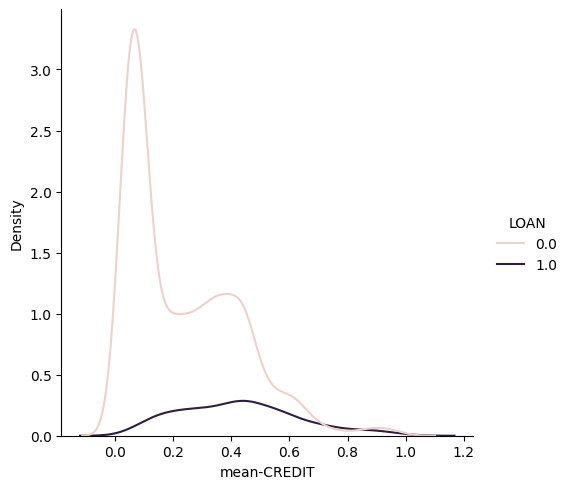

In [61]:
%matplotlib inline
sns.displot(model_df, x='mean-CREDIT',hue='LOAN',kind="kde")
plt.show()

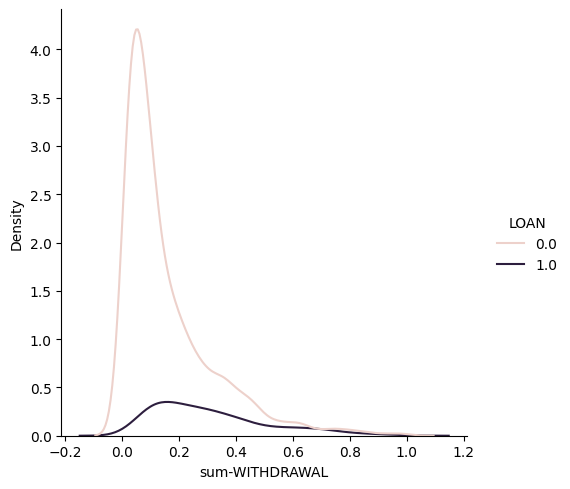

In [62]:
%matplotlib inline
sns.displot(model_df, x='sum-WITHDRAWAL',hue='LOAN',kind="kde")
plt.show()

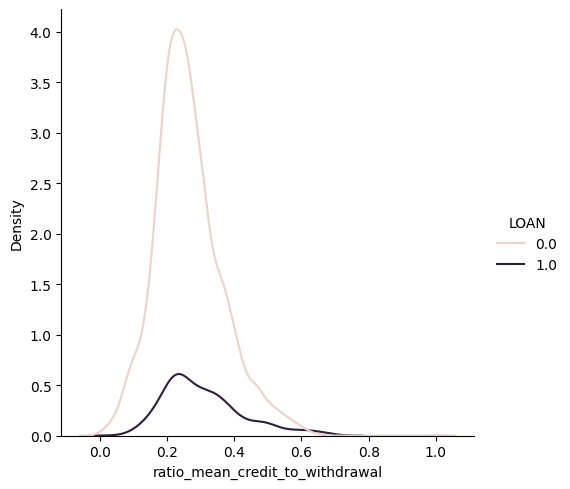

In [63]:
%matplotlib inline
sns.displot(model_df, x='ratio_mean_credit_to_withdrawal',hue='LOAN',kind="kde")
plt.show()



#### Check if there are null values in target column

In [64]:
np.sum(model_df['LOAN'].isna())

50

In [65]:
model_df.shape

(4450, 33)

#### Drop these rows as the count is very low compared to full dataset size

In [66]:
model_df = model_df.dropna(how='any',axis=0)

In [67]:
model_df.shape

(4400, 33)

#### Seperate out training and testing file by using the SET_SPLIT flag

In [68]:
train_data = model_df[model_df['SET_SPLIT']=='TRAIN']
test_data = model_df[model_df['SET_SPLIT']=='TEST']


In [69]:
train_data['LOAN'].value_counts()

0.0    2992
1.0     529
Name: LOAN, dtype: int64

## <font color='red'>Section 5 - Prepare train test split and define functions for model performance analysis

### I will use lightGBM classifier model for the problem
### Initially I will train a logistic regression model to create a baseline

#### Import necessary packages

In [70]:
!pip install lightgbm


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [71]:
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import *

import lightgbm as lgb

#### Split the training data in train/validation split with 80:20 ratio

In [72]:
X_train, X_validation, y_train, y_validation = train_test_split(train_data, train_data.LOAN, test_size=0.2, random_state=42)

In [73]:
X_train.columns

Index(['mean-CREDIT', 'sum-WITHDRAWAL', 'sum-CREDIT',
       'mean-WITHDRAWAL-WITHDRAWAL_IN_CASH',
       'sum-WITHDRAWAL-WITHDRAWAL_IN_CASH',
       'sum-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK', 'mean-WITHDRAWAL',
       'mean-CREDIT-COLLECTION_FROM_OTHER_BANK',
       'mean-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK',
       'sum-CREDIT-COLLECTION_FROM_OTHER_BANK', 'count-WITHDRAWAL',
       'sum-CREDIT-CREDIT_IN_CASH', 'count-WITHDRAWAL-WITHDRAWAL_IN_CASH',
       'mean-CREDIT-CREDIT_IN_CASH',
       'count-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK',
       'ratio_mean_credit_to_withdrawal', 'ratio_count_credit_to_withdrawal',
       'ratio_sum_WITHDRAWAL_IN_CASH_to_WITHDRAWAL',
       'count-CREDIT-CREDIT_IN_CASH', 'age_in_years_during_first_transaction',
       'count-CREDIT', 'ratio_sum_REMITTANCE_TO_OTHER_BANK_to_WITHDRAWAL',
       'ratio_sum_credit_to_withdrawal', 'mean-WITHDRAWAL-CC_WITHDRAWAL',
       'count-CREDIT-COLLECTION_FROM_OTHER_BANK',
       'ratio_sum_CC_WITHDRAWAL_to_WITHDRAWAL',

#### Label encode target class

In [74]:
from sklearn.preprocessing import LabelEncoder

In [75]:
enc = LabelEncoder()
enc_fitted = enc.fit(y_train)
y_train_encoded = enc_fitted.transform(y_train)
y_validation_encoded = enc_fitted.transform(y_validation)

### Define functions for model metric calculation
#### I will define some functions which will be usefull to get model metric for different model experiments
    - Function to create prediction output with ranked probabilities, get AUC-ROC and KS test statistic
    - Function to create confusion matrix, depending on the chosen threshold level
    - Function to create precision-recall curve
    - Function to create pentile-wise hit rate for ranked prediction outcomes
    - Function to identify optimal threshold giving best f1-score

### When comparing between models, we would mainly check the roc-auc value, f1-score and KS statistic to identify which model performs better


##### Base function to return prediction outputs with ranked precision, ranked recall, AUC-ROC and KS statistic

    - Higher AUC-ROC value means better performance on TPR and FPR (higher TPR corresponds to lower FPR)
    - Higher F1-Score is better
    - Higher KS statistic with lower p-value denotes model is better in seperating positive and negative class

#### Function for ranked result output with ROC-AUC and KS Stat

In [76]:
from scipy.stats import ks_2samp

In [77]:
def create_prediction_df(df,model,input_columns):
    """
    Given a test dataset, this function returns a result dataset with prediction outcomes.
    Generates class predictions, probabilities and calculates rank wise precision and recall at top N records
    It also returns the AUC-ROC and KS statistic values
    
    Input
    ----------
    df : dataframe with model input columns
    model : trained model object
    input_columns : model input columns
    
    Output
    ----------
    validation_results : dataframe with predictions, probabilities, rank, precision-at-rank and recall-at-rank
    fpr : false positive rates for different probability thresholds
    tpr : true positive rates for different probability thresholds
    roc_auc : Area under curve for ROC
    ks : ks statistic with p-value
    """
    
    #### Predict class and probabilities
    y_validation_pred_encode = model.predict(df[input_columns])
    y_validation_pred_class = enc_fitted.inverse_transform(y_validation_pred_encode)
    y_validation_pred_probabilities = model.predict_proba(df[input_columns])[:, 1]

    validation_results = df.copy()
    
    #### Add the predictions to the file
    validation_results['y_pred_class'] = y_validation_pred_class
    validation_results['y_pred_probabilities'] = y_validation_pred_probabilities
    
    #### Rank by descending probability
    validation_results = validation_results.sort_values('y_pred_probabilities', ascending=False)
    #### Cumulative true positive at rank
    validation_results['y_true_cumsum'] = validation_results['LOAN'].cumsum(axis = 0)
    #### Row count (i,e, rank)
    validation_results['row_count'] = range(1,validation_results.shape[0]+1,1)
    
    #### Precision and recall at rank
    validation_results['precision_at_row'] = validation_results['y_true_cumsum']/validation_results['row_count']
    validation_results['recall_at_row'] = validation_results['y_true_cumsum']/np.sum(validation_results['LOAN'])
    
    #### Calculate F1-Score
    f1 = f1_score(validation_results['LOAN'],validation_results['y_pred_class'])

    #### Calculate ROC AUC
    fpr, tpr, threshold = roc_curve(validation_results['LOAN'], validation_results['y_pred_probabilities'])
    roc_auc = metrics.auc(fpr, tpr)
    
    #### Perform KS statistic
    neg_class = validation_results[validation_results['LOAN'] == 0]
    pos_class = validation_results[validation_results['LOAN'] == 1]
    ks = ks_2samp(neg_class['y_pred_probabilities'], pos_class['y_pred_probabilities'])
    
    return validation_results,fpr,tpr,f1,roc_auc,ks



#### Function to plot confusion matrix dependent on threshold

In [78]:

def print_confusion_matrix(result_df,threshold):
    """
    The function prints confusion matrix given a result dataframe, based on a given threshold
    
    Input
    ------
    result_df : dataframe with actual class and predicted probabilities
    threshold : Chosen threshold value for probability cut-off for positive/negative classification
        (if probability > threshold, then predicted positive, otherwise predicted negative)
    """
    
    #### Create flag for predicted positive
    result_df['pred_pos'] = result_df['y_pred_probabilities']>threshold
    result_df['pred_pos'] = result_df['pred_pos'].astype(int)
    
    #### Confusion matrix
    conf_mat = confusion_matrix(result_df['LOAN'], result_df['pred_pos'])
    conf_mat_df = pd.DataFrame(conf_mat,
                     index = ['No_Loan','Loan'], 
                     columns = ['No_Loan','Loan'])
    
    #### Plot confucion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_mat_df, annot=True)
    plt.ylabel('Actal Results')
    plt.xlabel('Predicted Results')
    plt.title('Confusion Matrix with threshold = '+str(threshold))

#### Function to plot precision-recall curve against probability threshold

In [79]:
def print_precision_recall_curve(results_df,model_type):
    """
    This function plots precision recall curve for predicted dataframe
    
    Input
    --------
    results_df : result dataframe with predictions
    model_type : input text to denote what was model type (for display in plot only)
    """
    sns.lineplot(data = results_df,\
             x = 'y_pred_probabilities',y='precision_at_row')
    sns.lineplot(data = results_df,\
             x = 'y_pred_probabilities',y='recall_at_row')
    plt.grid()
    plt.xlabel('Probability Thresholds')
    plt.ylabel('Precision and Recall')
    plt.title("Precision/Recall Curve for "+ model_type)

### Model calibration test

#### Create a function which will calculate pentile wise precision(i.e, hit rate) for ranked datasets
    - Rank dataset as per decreasing order of probability value
    - Break dataset in 20 equal size parts
    - calculate hit-rate in each pentile
    (ideally a better model should have higher hit rate in higher pentiles)

In [80]:
#### Define names of pentiles for easy readability
names_bins = ['Pentile_1','Pentile_2',\
             'Pentile_3','Pentile_4',\
             'Pentile_5','Pentile_6',\
             'Pentile_7','Pentile_8',\
              'Pentile_9','Pentile_10',\
              'Pentile_11','Pentile_12',\
             'Pentile_13','Pentile_14',\
             'Pentile_15','Pentile_16',\
             'Pentile_17','Pentile_18',\
              'Pentile_19','Pentile_20']


In [81]:

def bucket_analysis_on_prediction(results_df):
    """
    Pentile wise precision (i,e, hit-rate) calculation
    
    Input
    --------
    results_df : dataframe with prediction outcomes
    
    Output
    --------
    results_bin_group : dataframe with pentile level hit rate
    """
    #### Sort data in descending order of probabilities
    results_df = results_df.sort_values('y_pred_probabilities',ascending=False)
    
    #### Create bins for each row by dividing in ten equal parts
    results_df['bins'] = pd.qcut(results_df['y_pred_probabilities']\
                                               , q=np.arange(0,105,5)/100\
                                               ,labels = names_bins ).values

    #### Bin level aggregates - count of records and true positives in them
    results_bin_group = results_df.groupby(['bins'])['LOAN'].agg(['count','sum']).reset_index()
    
    #### Hit rate = true_pos/count for each bin
    results_bin_group['hit_rate'] = results_bin_group['sum']/results_bin_group['count']
    results_bin_group = results_bin_group.sort_values('bins',ascending=False)

    return results_bin_group
    

### Function for calculating F1-Score against different probability thresholds

#### Handling data copy warning for pandas

In [82]:
pd.options.mode.chained_assignment = None 

In [83]:
def f1_score_against_threshold(results_df,model_type):
    """
    This function will take prediction file with probability scores and actual targets 
    as inputs and generate a chart with f1-scores against probability thresholds
    This will help to identify which threshold to choose in order to obtain optimal precision and recall
    
    Input
    -----------
    results_df : model prediction dataframe with actuals and predicted probabilities
    model_type : free text to identify which model was used, used for plotting title only
    
    Output
    -----------
    Seaborn chart with f1-scores against probability threshold
    """
    f1_score_list = []
    for threshold in np.arange(0,105,5)/100 : 
        results_preds = results_df[['LOAN','y_pred_probabilities']]
        results_preds['pred_pos'] = results_preds['y_pred_probabilities']>threshold
        results_preds['pred_pos'] = results_preds['pred_pos'].astype(int)
        f1 = f1_score(results_preds['LOAN'],results_preds['pred_pos'])
        f1_score_list.append([threshold,f1])
    f1_score_df = pd.DataFrame(f1_score_list,columns=['Threshold','F1_Score'])
    
    sns.lineplot(data = f1_score_df,\
             x = 'Threshold',y='F1_Score')
    plt.grid()
    plt.xlabel('Probability Threshold')
    plt.ylabel('F1 Score at Threshold')
    plt.title("F1 Score against probability threshold for "+ model_type)

## <font color='red'>Section 6 - Train models - base classifier and fine tune with further complex model

### Modelling 1 - First train base logistic regression classifier

In [84]:
base_classifier = LogisticRegression(penalty='l2',max_iter=300)
base_classifier.fit(X_train[most_important_columns], y_train_encoded)


LogisticRegression(max_iter=300)

#### Calculate model metrics

In [85]:
validation_results_base,fpr_base,tpr_base,f1_score_base,roc_auc_base,ks_base = create_prediction_df(X_validation,base_classifier,input_columns=most_important_columns)

In [86]:
f1_score_base

0.15827338129496404

In [87]:
roc_auc_base

0.8124043542286259

In [88]:
ks_base

KstestResult(statistic=0.515260012127162, pvalue=1.750047944869912e-24)

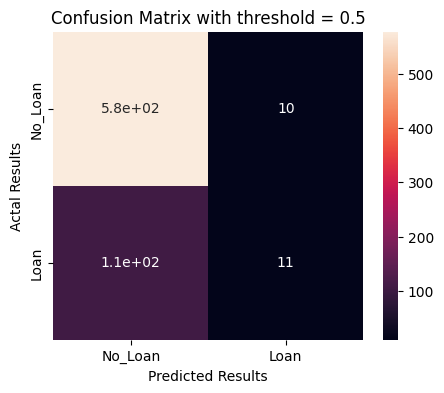

In [89]:
print_confusion_matrix(validation_results_base,threshold=0.5)

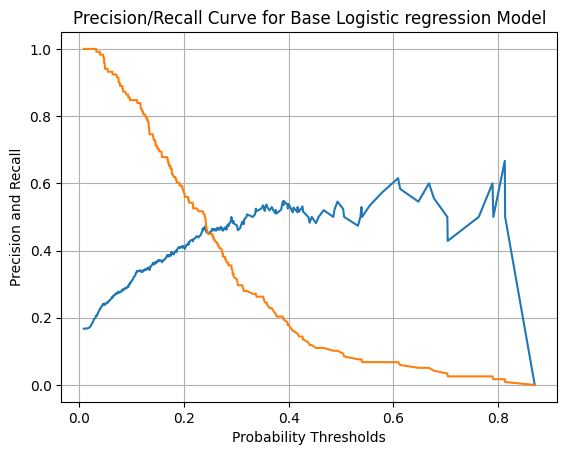

In [90]:
print_precision_recall_curve(validation_results_base,model_type='Base Logistic regression Model')

#### Run bucket wise analysis

In [91]:
validation_bin_group_base = bucket_analysis_on_prediction(validation_results_base)

In [92]:
validation_bin_group_base

,bins,count,sum,hit_rate
19,Pentile_20,36,19.0,0.527778
18,Pentile_19,35,15.0,0.428571
17,Pentile_18,35,15.0,0.428571
16,Pentile_17,35,13.0,0.371429
15,Pentile_16,35,9.0,0.257143
14,Pentile_15,36,9.0,0.250000
13,Pentile_14,35,8.0,0.228571
12,Pentile_13,35,8.0,0.228571
11,Pentile_12,35,4.0,0.114286
10,Pentile_11,35,2.0,0.057143


In [93]:
validation_results_base.head()

,mean-CREDIT,sum-WITHDRAWAL,sum-CREDIT,mean-WITHDRAWAL-WITHDRAWAL_IN_CASH,sum-WITHDRAWAL-WITHDRAWAL_IN_CASH,sum-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK,mean-WITHDRAWAL,mean-CREDIT-COLLECTION_FROM_OTHER_BANK,mean-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK,sum-CREDIT-COLLECTION_FROM_OTHER_BANK,...,ACCOUNT_ID,SET_SPLIT,LOAN,y_pred_class,y_pred_probabilities,y_true_cumsum,row_count,precision_at_row,recall_at_row,pred_pos
1888,0.936437,0.335125,0.331469,0.812722,0.270285,0.221605,0.740659,0.967551,0.819188,0.337794,...,2532,TRAIN,0.0,1.0,0.869777,0.0,1,0.000000,0.000000,1
2775,0.957414,0.387793,0.366274,0.704981,0.344432,0.157656,0.663934,0.983720,0.553656,0.372059,...,472,TRAIN,1.0,1.0,0.813284,1.0,2,0.500000,0.008475,1
3931,0.858531,0.172143,0.186755,0.581471,0.125936,0.166566,0.598877,0.881372,0.835634,0.192317,...,1718,TRAIN,1.0,1.0,0.812624,2.0,3,0.666667,0.016949,1
3397,0.912427,0.743988,0.736799,0.647581,0.543599,0.709948,0.523646,0.930700,0.474893,0.744628,...,844,TRAIN,0.0,1.0,0.790785,2.0,4,0.500000,0.016949,1
920,0.947553,0.486931,0.478350,0.526368,0.363641,0.444601,0.514794,0.953280,0.637283,0.485351,...,1093,TRAIN,1.0,1.0,0.789168,3.0,5,0.600000,0.025424,1


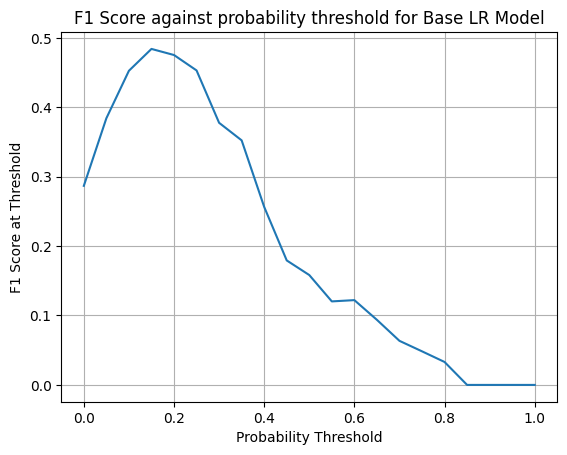

In [94]:
f1_score_against_threshold(validation_results_base,model_type='Base LR Model')

### Modelling 2 - Tuning on LightGBM classifier with hyperparameter tuning and cross-validation

##### Define lightGBM classifier with AUC as metric

In [95]:
classifier = lgb.LGBMClassifier(
            objective= 'binary',metric='f1',n_jobs=-1,
            n_estimators = 500)

##### Define hyperparameter grid search and cross validator

In [96]:
grid_param = {
    'subsample': [0.5,0.7,0.9,1.0],
    'max_depth': [3,5,7,9],
    'feature_fraction': [0.7,0.9],
    'learning_rate' : [0.008,0.0008]
}

model_grid = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='f1',
                     cv=4,
                     n_jobs=-1)

In [97]:
import time

##### Start training

In [98]:
start_time = time.time()

model_grid.fit(X_train[most_important_columns], y_train_encoded)
end_time = time.time()

print('time taken to train :',end_time-start_time)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
time taken to train : 159.2909984588623


##### What are the final best parameters for the model

In [99]:
best_parameters = model_grid.best_params_
print(best_parameters)

{'feature_fraction': 0.7, 'learning_rate': 0.008, 'max_depth': 9, 'subsample': 0.5}


#### Run model performance metrics

In [100]:
validation_results_tuned,fpr_tuned,tpr_tuned,f1_score_tuned,roc_auc_tuned,ks_tuned = create_prediction_df(X_validation,model_grid,input_columns=most_important_columns)

In [101]:
f1_score_tuned

0.5824175824175823

In [102]:
roc_auc_tuned

0.9261542459503941

In [103]:
ks_tuned

KstestResult(statistic=0.6972829382380966, pvalue=3.6154967449612267e-47)

### Key observation
#### Tuned model is better than base model, ROC-AUC is higher(~ 0.93 against ~ 0.81), F1-Score is higher (0.58 against 0.15), KS statistic is higher (~ 0.7 against ~ 0.5) with far lower p-value of significance (in the scale of e-47 compared to e-24)


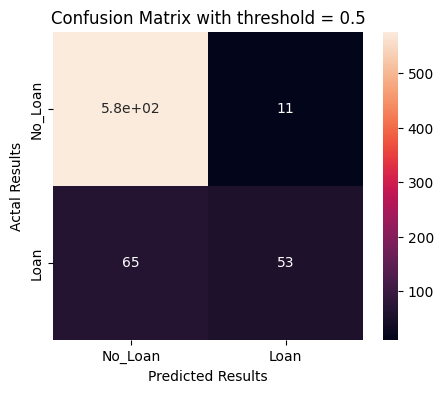

In [104]:
print_confusion_matrix(validation_results_tuned,threshold=0.5)

### Comparison on confusion matrix - with similar false positive, tuned model can capture nearly 5 times true positives

## Bucket analysis for predcition outcomes

#### Compare population bucket wise performance between models

In [105]:
validation_bin_group_tune = bucket_analysis_on_prediction(validation_results_tuned)

#### Join bucket analysis metric for fine tuned model and base model

In [106]:
validation_bin_group_combined = validation_bin_group_tune.merge(validation_bin_group_base[['bins','hit_rate']],on='bins')

In [107]:
validation_bin_group_combined.columns = ['bins','count','sum','hit_rate_tuned_lgb_model','hit_rate_base_lr_model']

#### Create proper structure and plot

In [108]:
validation_bin_group_combined_melted = pd.melt(validation_bin_group_combined[['bins','hit_rate_tuned_lgb_model','hit_rate_base_lr_model']], id_vars="bins", var_name="model_type", value_name="hit_rate")

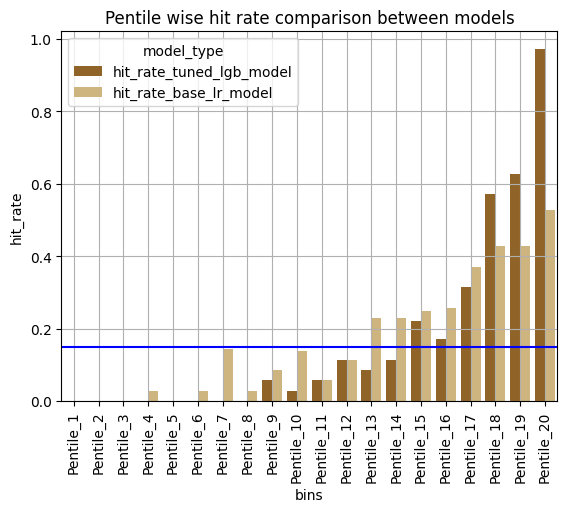

In [109]:

sns.barplot(data=validation_bin_group_combined_melted,\
            x='bins', y='hit_rate', hue='model_type', palette=sns.color_palette('BrBG'),\
           )
plt.axhline(y=0.15, color='b', linestyle='-')
plt.xticks(rotation = 90)
plt.title('Pentile wise hit rate comparison between models')
plt.grid()

#### Also compare ROC for both models

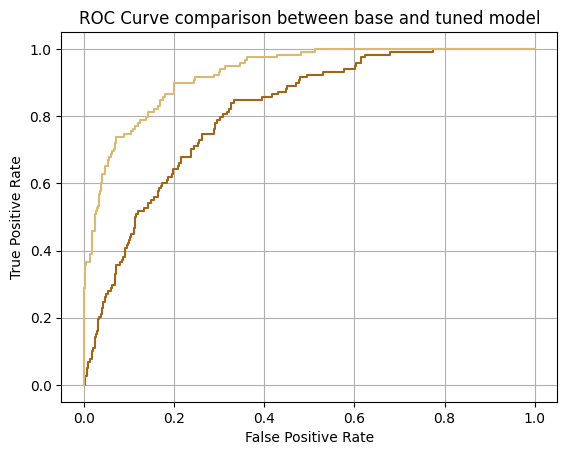

In [110]:
sns.set_palette("BrBG")
plt.plot(fpr_base,tpr_base)
plt.plot(fpr_tuned,tpr_tuned)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve comparison between base and tuned model')
plt.grid()
plt.show()


### Precision recall curve for tuned model - useful for busines to identify right threshold

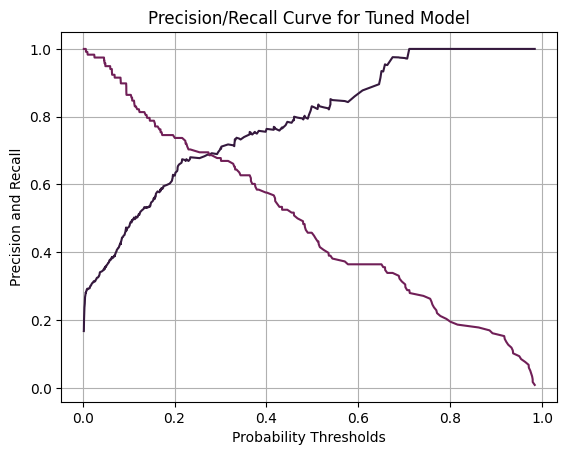

In [111]:
sns.set_palette("rocket")
print_precision_recall_curve(validation_results_tuned, model_type='Tuned Model')

##### What is the expected hit rate (precision) if we want to capture 50% of eligible customers?

In [112]:
validation_results_tuned[validation_results_tuned['recall_at_row']<0.5]['precision_at_row'].min()

0.7916666666666666

##### What percentage of customers we have to target to get the 50% eligible population?

In [113]:
validation_results_tuned[validation_results_tuned['recall_at_row']<0.5]['row_count'].max()/validation_results_tuned.shape[0]

0.10354609929078014

#### In order to capture 50% of all eligible customers, we can target only 10% of all customers and the model can have 80% hit rate for the selected customers

#### Check what threshold value would give maximum F1-Score

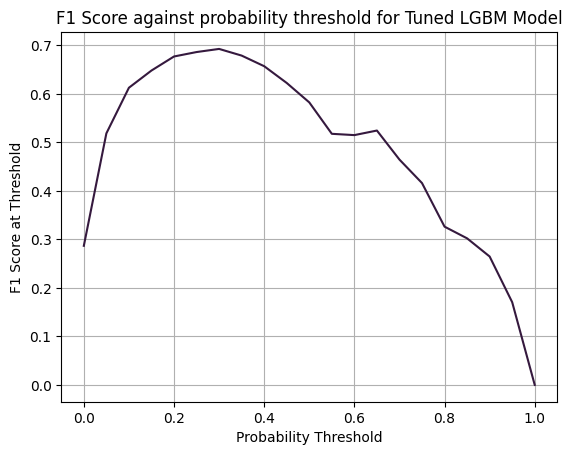

In [114]:
f1_score_against_threshold(validation_results_tuned,model_type='Tuned LGBM Model')

#### We can select threshold = 0.3, which will expect precision ~71%, and recall ~68%, with F1-Score = ~0.7

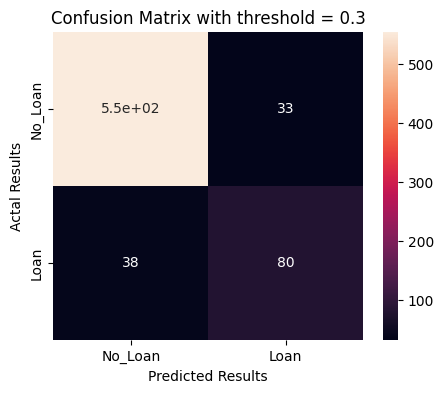

In [115]:
print_confusion_matrix(validation_results_tuned,threshold=0.3)

## <font color='red'>Section 7 - Analysis of feature importance

### Create feature importance from lightGBM model

##### Create dataframe with importance for each feature from model

In [116]:
feat_imp_df = pd.DataFrame(list(zip(most_important_columns,list(model_grid.best_estimator_.feature_importances_))),columns=['feature_name','importance'])

##### Get most important features which imparts 95% weightage on total feature importance

In [117]:
#### Rank by decreasing feature importance
feat_imp_df = feat_imp_df.sort_values('importance',ascending=False)

#### Calculate cumulative feature importance
feat_imp_df['cumulative_importance'] = feat_imp_df['importance'].cumsum()

#### Calculate percentage of total importance captured
total_importance = np.max(feat_imp_df['cumulative_importance'])
feat_imp_df['pct_of_imp_captured'] = feat_imp_df['cumulative_importance']/total_importance

#### Take upto which feature importance is captured for 95% of total importance
feat_imp_df[feat_imp_df['pct_of_imp_captured']<=0.95].shape

(22, 4)

In [118]:
feat_imp_df.shape

(30, 4)

In [119]:
feat_imp_df[feat_imp_df['pct_of_imp_captured']<=0.95]['feature_name'].values

array(['ratio_mean_credit_to_withdrawal',
       'mean-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK', 'mean-CREDIT',
       'ratio_sum_REMITTANCE_TO_OTHER_BANK_to_WITHDRAWAL',
       'mean-WITHDRAWAL-WITHDRAWAL_IN_CASH',
       'count-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK',
       'mean-CREDIT-CREDIT_IN_CASH',
       'count-WITHDRAWAL-WITHDRAWAL_IN_CASH',
       'ratio_sum-CREDIT_IN_CASH_to_CREDIT',
       'ratio_sum_WITHDRAWAL_IN_CASH_to_WITHDRAWAL',
       'sum-WITHDRAWAL-REMITTANCE_TO_OTHER_BANK',
       'age_in_years_during_first_transaction',
       'ratio_count_credit_to_withdrawal', 'sum-CREDIT-CREDIT_IN_CASH',
       'mean-WITHDRAWAL', 'uplift_from_average_URBAN_RATIO',
       'ratio_sum_credit_to_withdrawal', 'count-CREDIT',
       'count-WITHDRAWAL', 'sum-WITHDRAWAL-WITHDRAWAL_IN_CASH',
       'sum-WITHDRAWAL', 'sum-CREDIT'], dtype=object)

#### So there are 22 features having 95% importance captured

#### Plot feature importance as bar chart

In [120]:
sns.set_palette("Purples_d")

Text(0.5, 1.0, 'Feature Importance from trained LGB model')

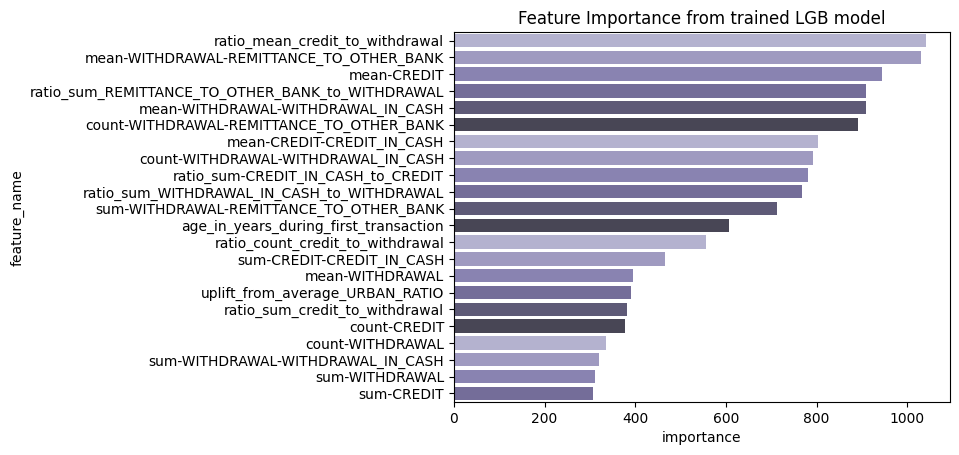

In [121]:
sns.barplot(data =feat_imp_df[feat_imp_df['pct_of_imp_captured']<=0.95], \
            y= 'feature_name',x='importance',palette=sns.color_palette('Purples_d'))
plt.title('Feature Importance from trained LGB model')


#### Feature importance using SHAP

In [122]:
!pip install shap


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [123]:
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


#### Create tree explainer for shap

In [124]:

explainer = shap.TreeExplainer(model_grid.best_estimator_)
shap_values = explainer.shap_values(X_train[most_important_columns])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


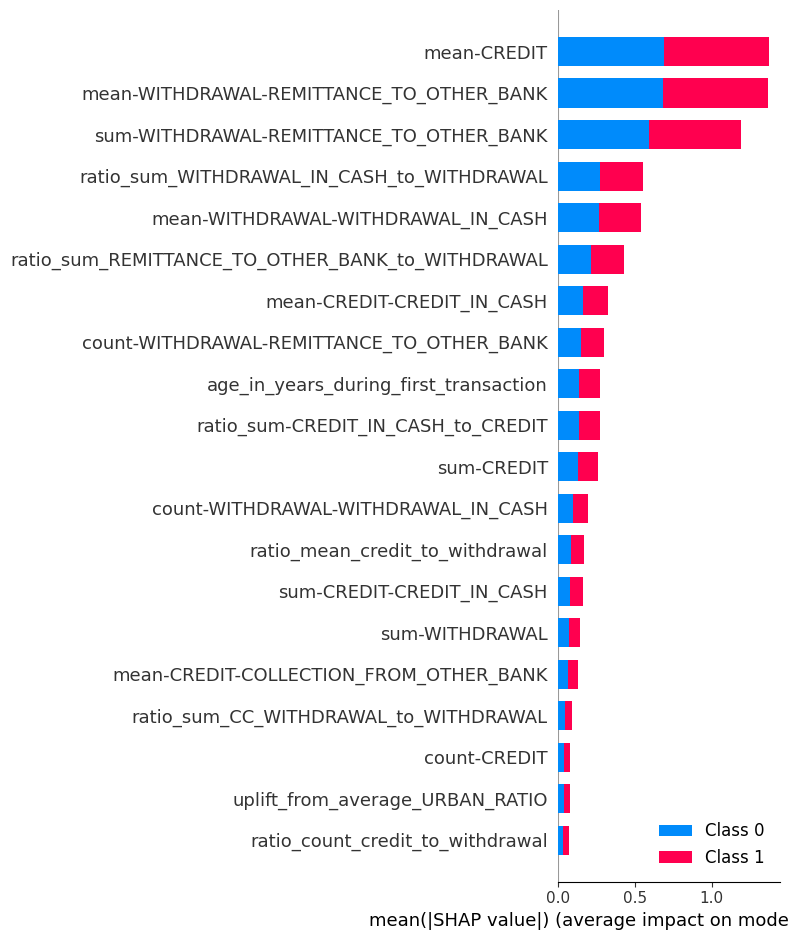

In [125]:
shap.summary_plot(shap_values, X_train[most_important_columns], feature_names=most_important_columns, plot_type="bar")

## <font color='red'>Section 8 - Run model predictions on test set and calculate performance

### Run on test records

In [126]:
test_results_tuned,fpr_tuned_test,tpr_tuned_test,f1_score_tuned_test,roc_auc_tuned_test,ks_tuned_test = create_prediction_df(test_data,model_grid,input_columns=most_important_columns)

In [127]:
f1_score_tuned_test

0.6244343891402715

In [128]:
roc_auc_tuned_test

0.9213475119402376

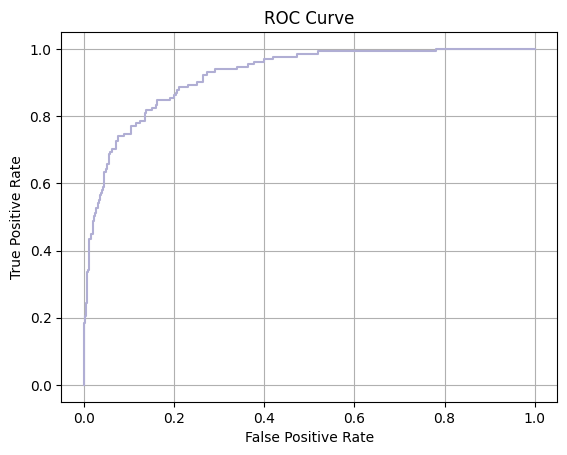

In [129]:
plt.plot(fpr_tuned_test,tpr_tuned_test)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.show()


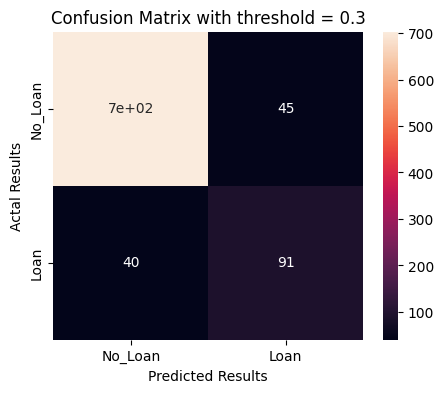

In [130]:
print_confusion_matrix(test_results_tuned,threshold=0.3)

### For test data, 67% precision, 70% recall at threshold = 0.3

### Compare with random selection - business benefit

In [131]:
data_size = test_results_tuned.shape[0]
loan_count = test_results_tuned['LOAN'].sum()
base_prevalence = loan_count/data_size
base_prevalence

0.149032992036405

#### Baseline prevalence = 15%, so any random selection of customers would have 15% loan eligible customers among them
    

#### Assume bank has decided to give loan to 15% of its customer base
Let us create simulation and check what can be the expected hit rate in the selected population

In [132]:
import random

In [138]:
list_of_hit_rates = []
for i in range(1000):
    random_number = int(random.random()*1000)
    randomly_selected_customers = test_results_tuned.sample(frac=0.15,random_state=random_number)
    hit_rate = randomly_selected_customers['LOAN'].sum()/randomly_selected_customers.shape[0]
    list_of_hit_rates.append(hit_rate)

In [139]:
print(np.min(list_of_hit_rates))
print(np.mean(list_of_hit_rates))
print(np.std(list_of_hit_rates))
print(np.max(list_of_hit_rates))

0.045454545454545456
0.14870454545454545
0.029825170674869974
0.24242424242424243


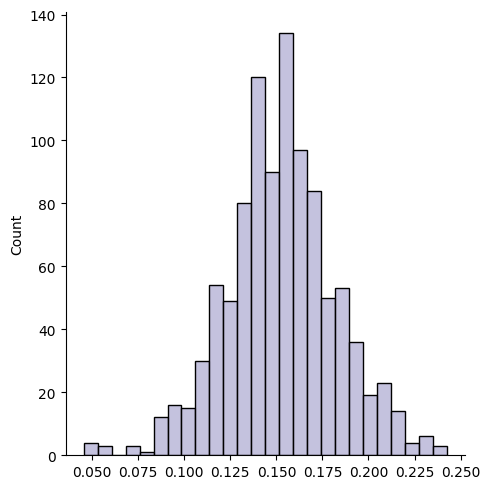

In [140]:
sns.displot(list_of_hit_rates)

#### So average hit rate for simulations ~15%
#### maximum being ~24%

#### Now from trained model predictions, let us take the top 15% population with highest probabilities 

In [136]:
row_count_for_top_20_pct = np.ceil(test_results_tuned.shape[0]*0.15)
row_count_for_top_20_pct

132.0

#### What is the hit rate (precision) when we reach 132th record from top?

In [137]:
test_results_tuned[test_results_tuned['row_count']<=row_count_for_top_20_pct]['precision_at_row'].min()

0.671875

#### Hence with model we can expect a 67/15 = ~4.5 times uplift in hit rate

## Further thoughts - what could have been done more in a real life modelling exercise

#### 1. Overall, understand the data more closely. Like if LOAN == 1 means loan has been granted and not has been defaulted yet? Do we have indication that which loans defaulted after approval? Also understand more about the type of loans, value, duration, etc etc
#### 2. Model bias check - group wise FPR, on gender and location
#### 3. Swap set analysis for multiple models
#### 4. Create more granular trend variables from transaction data - like change in debit and credit patterns etc
#### 5. Calculate cost-benefit analysis of selected model - explain to business about the potential monetory saving the model can bring in when it reduces false positives
#### 6. Ideally if the loan application date is present, a different type of experiment could have been performed - taking temporal features